In [1]:
import os

import numpy as np
import tensorflow as tf
from matplotlib.colors import Normalize
from extract_modis_data import extract_1km_data
from functions import process_label_maps, convert_to_day_of_year, generate_patches
from autoencoder import SimpleAutoencoder
import xarray as xr
from tensorflow.keras.models import load_model
import joblib
import numpy as np
import matplotlib.colors as mcolors


total cores: 256


In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,"  , len(logical_gpus), "Logical GPUs")
        tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

import socket





1 Physical GPUs, 1 Logical GPUs


In [ ]:

data_loc = "/location_of_data_including_nimbus_sea_ice_mask_if_used"

bands = [31]

band_str = "31"
model_run_name = f"dnb_ice01_l95_z50_ps128_band{band_str}"
patch_load_name = f"dnb_ice01_l95_z50_ps128_band{band_str}"

max_vals = np.load(f"{data_loc}models/patch_size128/filter128/max_val_{patch_load_name}_2019-2023.npy")
min_vals = np.load(f"{data_loc}models/patch_size128/filter128/min_val_{patch_load_name}_2019-2023.npy")
encoder = load_model(f"{data_loc}models/patch_size128/filter128/encoder_{model_run_name}.h5")

In [ ]:
### EXTRACT CAO AND NOn CAO CASES
patch_size = 128
start = "20210321"
end = "20210321"

# example dates containing CAOs to look at
date_list = ["2021080", "2023062", "2023065", "2019060", "2022347", "2022120"]

start_converted = convert_to_day_of_year(start)
end_converted = convert_to_day_of_year(end)

folder = "folder_containing_MODIS_npz_files multiple_folders_is_seperated_by_space_in_this_string"
ds_water_mask=xr.open_dataset(f"{data_loc}/land_sea_ice_mask/nimbus/with_lonlat/NSIDC0051_SEAICE_PS_N25km_20200302_v2.0.nc")

x_cao, dates_cao, masks_cao, lon_lats_cao, mod_min_cao = extract_1km_data(folder,
                                                        #  start_date=start_converted,
                                                        bands=bands,
                                                        #  end_date=end_converted,
                                                        ds_water_mask=ds_water_mask,
                                                        date_list=date_list,
                                                         return_lon_lat=True,
                                                         data_loc=data_loc,
                                                         data_type="npz",
                                                         combine_pics=False,)
                                                        #  lon_min=-55,
                                                        #  lon_max=65,
                                                        #  lat_min=55,
                                                        #  lat_max=82)


x_cao, dates_cao, masks_cao, lon_lats_cao, mod_min_cao = zip(*[(xi, date, mask, lon_lat, mod_min) for xi, date, mask, lon_lat, mod_min in zip(x_cao, dates_cao, masks_cao, lon_lats_cao, mod_min_cao) if (xi.shape[0] > patch_size) and (xi.shape[1] > patch_size)])
x_cao = list(x_cao)
dates_cao = list(dates_cao)
len(x_cao)



defaultdict(<class 'list'>, {'2019311': [830, 650, 2130, 5, 1950, 1500, 1145, 510, 1635, 145, 1815, 330, 2310, 1325, 1005], '2019021': [2005, 15, 2140, 205, 840, 700, 1650, 525, 345, 1200, 1825, 1335, 2320, 1515, 1020], '2019144': [330, 1810, 645, 0, 1455, 2125, 505, 1000, 1140, 1320, 1630, 135, 2305, 1945, 825], '2019041': [1625, 2120, 1135, 130, 2255, 955, 635, 320, 1800, 500, 1940, 815, 1450, 1310], '2019261': [1515, 705, 525, 2005, 840, 1335, 1830, 15, 345, 2320, 1020, 1650, 2140, 1200], '2019059': [2245, 945, 625, 1615, 1435, 1930, 1750, 305, 445, 1300, 2105, 120, 1120, 805], '2019077': [750, 1425, 2055, 1735, 255, 1915, 435, 2230, 105, 930, 1600, 1110, 1245, 615], '2019335': [240, 55, 1235, 1550, 920, 2040, 1725, 600, 2220, 1905, 420, 1410, 1055, 740], '2019105': [1800, 1940, 130, 1450, 1135, 955, 815, 500, 2255, 1625, 640, 2120, 1310, 320], '2019249': [1805, 2120, 320, 130, 1940, 1310, 2255, 815, 955, 1135, 640, 1450, 500, 1625], '2019038': [1910, 605, 425, 1555, 100, 1730, 2225

100%|██████████| 6/6 [00:54<00:00,  9.02s/it]


74

In [ ]:
# These indices looked like nice CAOs
idx = [4, 24, 40, 45, 53, 54] #, 52

# Extract elements based on the indices
x_test = [x_cao[i] for i in idx]
dates_test = [dates_cao[i] for i in idx]
masks_test = [np.where(masks_cao[i]>0.1, 0, 1) for i in idx]
lon_lats_test = [lon_lats_cao[i] for i in idx]
mod_min_test = [mod_min_cao[i] for i in idx]


In [8]:
autoencoder_predict = SimpleAutoencoder(len(bands), patch_size, patch_size)
strides = patch_size//4
patches_test, all_lon_patches_test, all_lat_patches_test, starts_test, ends_test, shapes_test, n_patches_tot_test, indices_test = generate_patches([x for x in x_test],
                                                                                                                                        masks_test,
                                                                                                                                        lon_lats_test,
                                                                                                                                        max_vals,
                                                                                                                                        min_vals,
                                                                                                                                        autoencoder_predict,
                                                                                                                                        strides=[1, strides, strides,1])

In [ ]:
# Can be computed on GPU as well
with tf.device('/CPU:0'):   
    encoded_patches_cao = encoder.predict(patches_test)
    encoded_patches_flat_cao = encoded_patches_cao.reshape(encoded_patches_cao.shape[0], -1)

In [ ]:
# Loading a clustering model - change directory to where the model is stored
n_K = 7
global_max = n_K
cluster = joblib.load(f"{data_loc}models/patch_size128/filter128/clustering/K{n_K}/cluster_{model_run_name}_filter128_K{n_K}.pkl" )
labels = cluster.predict(encoded_patches_flat_cao)
labels_transformed = cluster.transform(encoded_patches_flat_cao)

In [11]:
cao_idxs = np.isin(labels, [10, 2])
cao_idxs_true = np.isin(labels, [6, 9])


In [12]:
extra_labels_mask = (cao_idxs) & (labels_transformed[:, 5] < 20)

lab_test = np.where(extra_labels_mask  | cao_idxs_true, 1, 0)
label_map, lon_map, lat_map = process_label_maps(labels,
                                                all_lon_patches_test,
                                                all_lat_patches_test,
                                                starts_test,
                                                ends_test,
                                                shapes_test,
                                                indices_test,
                                                global_max,
                                                n_patches_tot_test,
                                                patch_size,
                                                strides,
                                                [2, 10], 
                                                [], 
                                                size_thr_1=None, 
                                                size_thr_2=None)


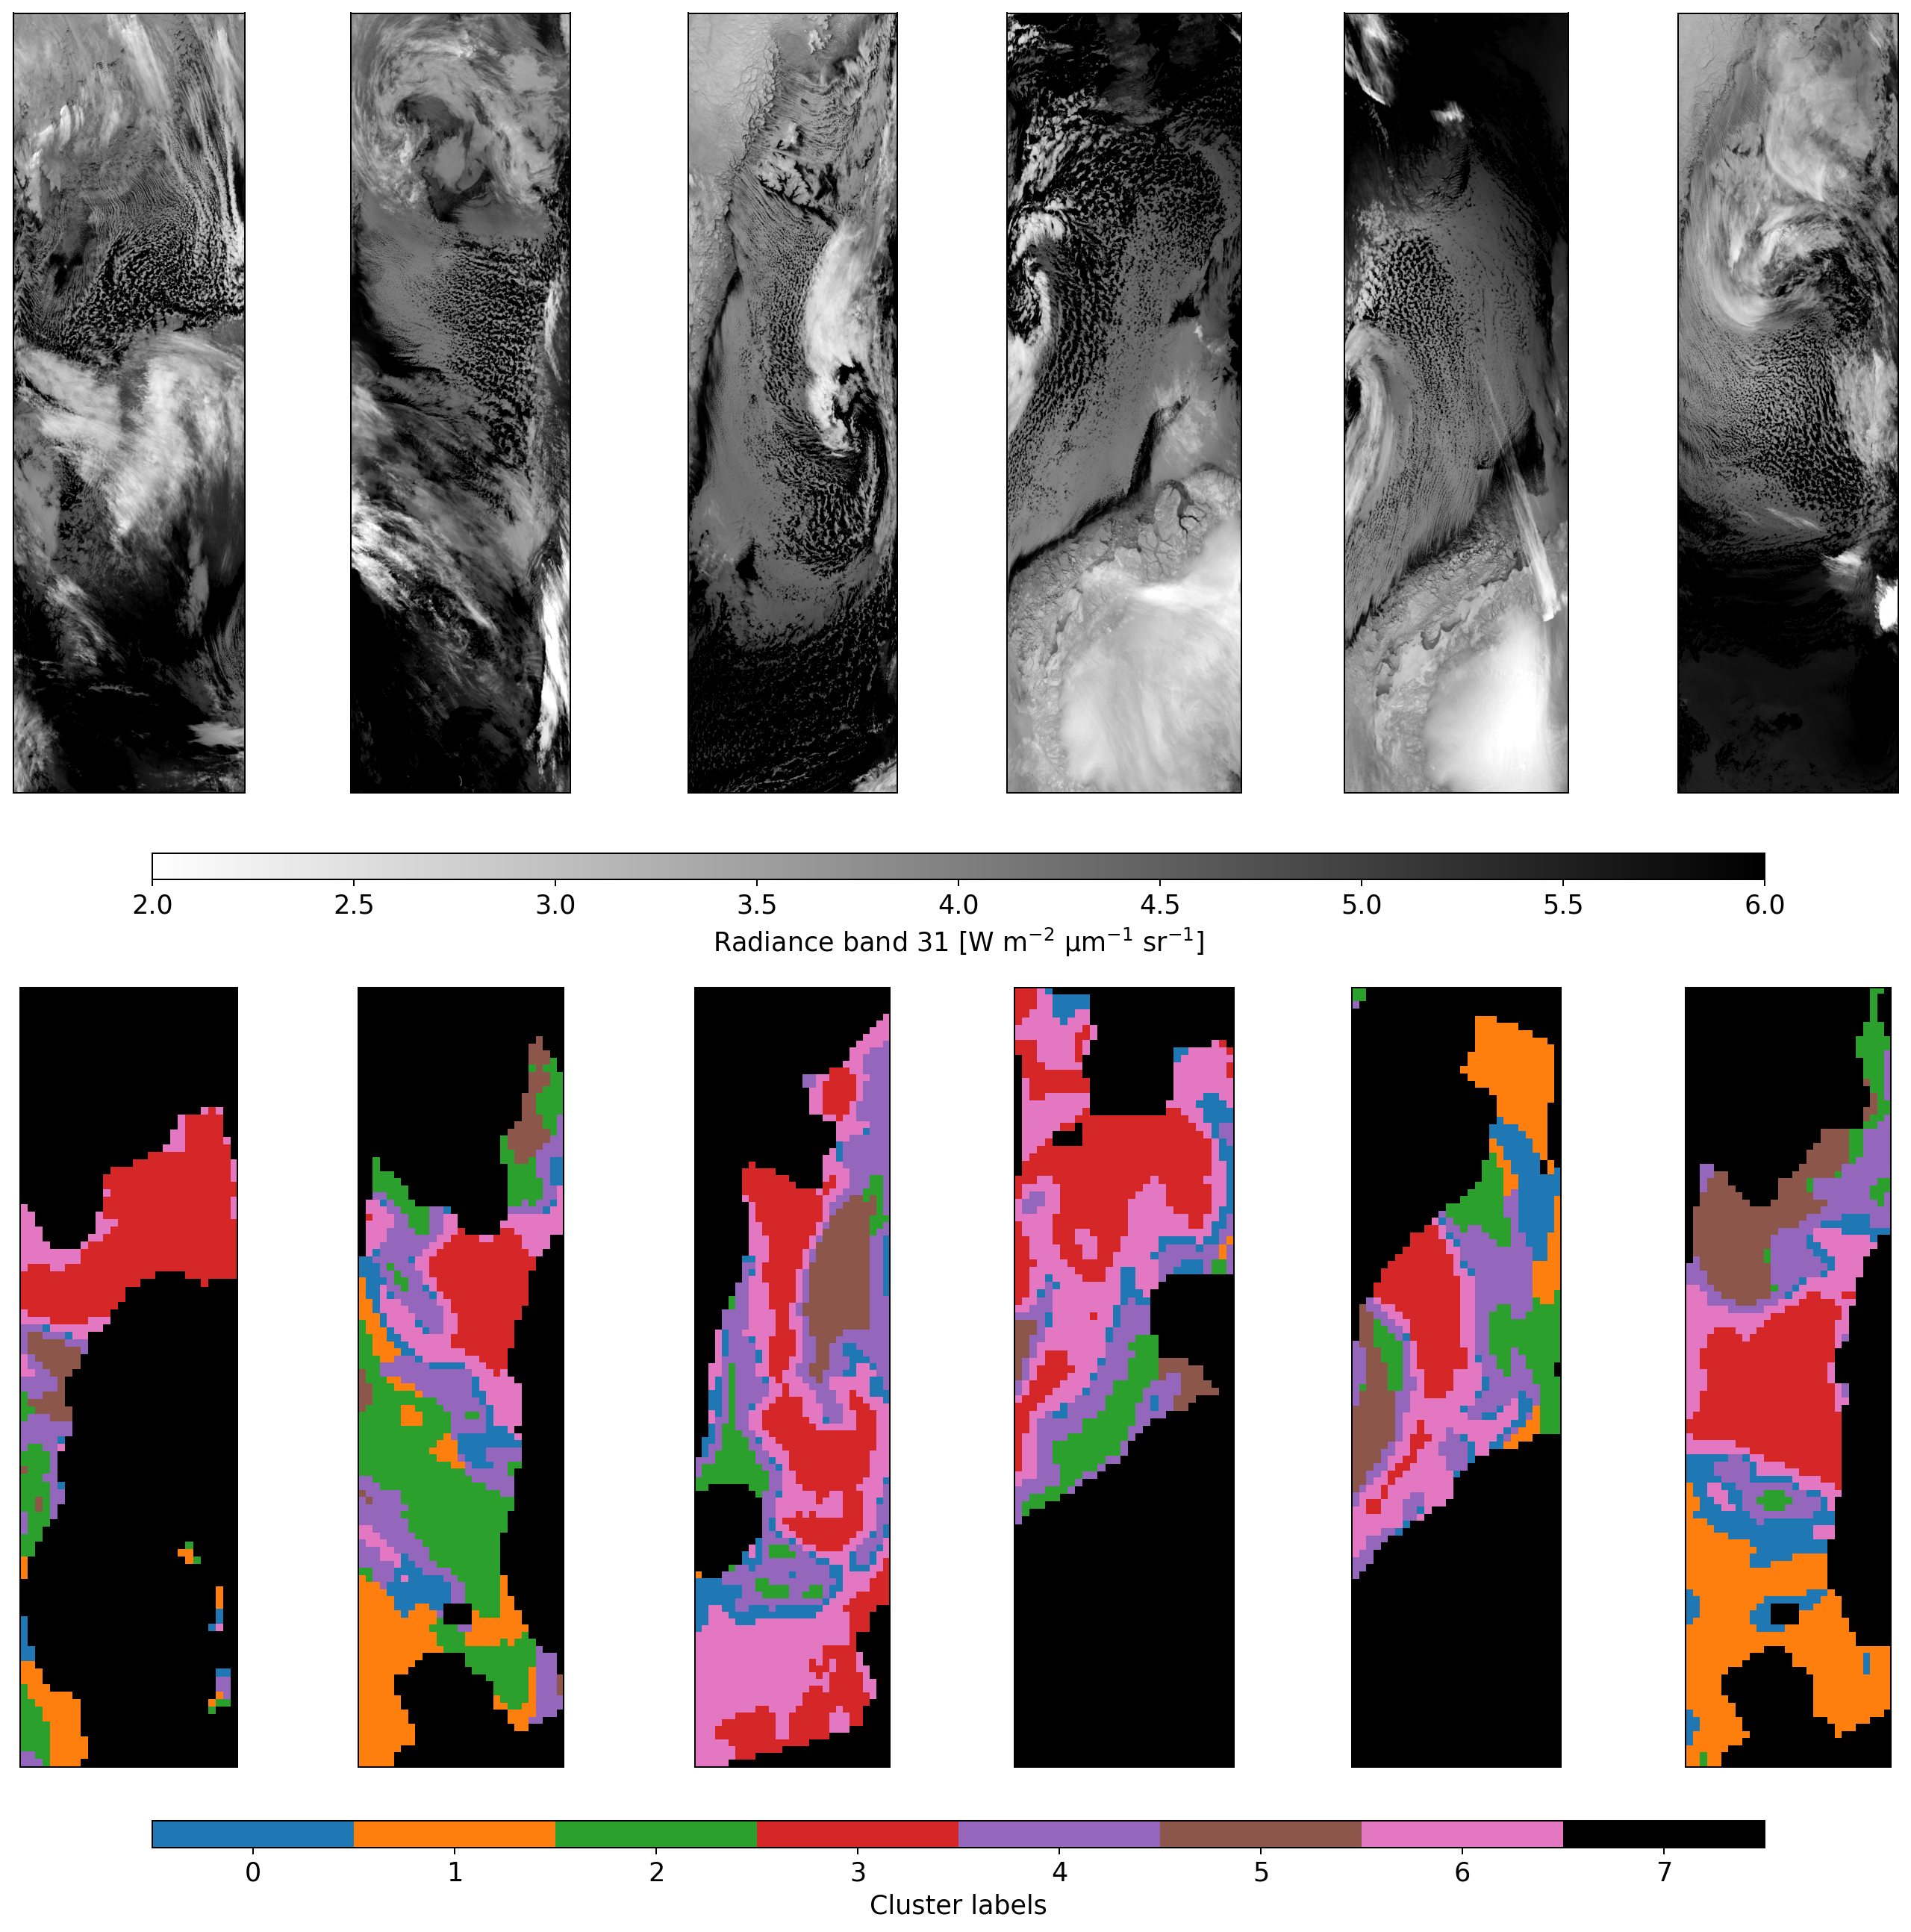

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

norm_mask = Normalize(vmin=0, vmax=1)  
matplotlib.rcParams.update({'font.size': 14})
   
cmap_tab10 = plt.cm.tab10
cmap_tab20 = plt.cm.tab20
colors_tab20 = cmap_tab20(np.arange(cmap_tab20.N))[1::2]
colors_tab10 = cmap_tab10(np.arange(cmap_tab10.N))
extra_colors = colors_tab20
black = np.array([0, 0, 0, 1])
colors_new = np.vstack((colors_tab10, colors_tab20))[:n_K]
colors_new = np.vstack((colors_new, black))

colors_final= np.vstack((colors_tab10, colors_tab20))[:n_K]
colors_final= np.vstack((colors_final, black))

new_cmap = mcolors.ListedColormap(colors_final)
norm = Normalize(vmin=0, vmax=n_K+1)

fig, axs = plt.subplots(2, 6, figsize=[15, 15], dpi=180)

# Plot the images and hide ticks
for i in range(2):
    for j in range(6):
        if i == 0:
            # cb = axs[i, j].imshow(x_test[j][:,:,1], cmap="gray_r", vmax=6, vmin=2)
            cb = axs[i, j].imshow(x_test[j][:,:,0], cmap="gray_r", vmax=6, vmin=2)

            # cb = axs[i, j].pcolormesh(lon_lats_test[j][0], lon_lats_test[j][1], x_test[j][:,:,1], cmap="gray_r", vmax=6, vmin=2)
            # isnan = np.isnan(lon_map[j])
            # cb2 = axs[i, j].scatter(lon_map[j][~isnan], lat_map[j][~isnan], c=label_map[j][~isnan], cmap=new_cmap, vmax=None, vmin=None, norm=norm, alpha=0.3)

        else:
            cb2 = axs[i, j].imshow(label_map[j], cmap=new_cmap, vmax=None, vmin=None, norm=norm)
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])

# Common colorbar for the first row
cbar_ax = fig.add_axes([0.1, 0.55, 0.8, 0.013])  # xpos, ypos, width, height
fig.colorbar(cb, cax=cbar_ax, orientation='horizontal', label=r"Radiance band 31 [W m$^{-2}$ µm$^{-1}$ sr$^{-1}$]")

# Common colorbar for the second row
boundaries = np.arange(0, n_K+2, 1)  # Specify the boundaries of the segments
n_boundaries = len(boundaries)
tick_positions = (boundaries[:-1] + boundaries[1:]) / 2   # Calculate middle points
tick_labels = boundaries[:-1] 
cbar_ax = fig.add_axes([0.1, 0.07, 0.8, 0.013])  # xpos, ypos, width, height
cbar = fig.colorbar(cb2, cax=cbar_ax, orientation='horizontal', boundaries=boundaries, ticks=tick_positions)
cbar.set_label("Cluster labels")
cbar.set_ticklabels(tick_labels)  # Replace with your labels

# Customize the tick labels if needed
# Adjust the layout to make space for the colorbars and reduce the spacing between subplots in the x-direction
fig.subplots_adjust(hspace=0.25, wspace=0.05, left=0.01, right=0.99, top=0.98)
# fig.savefig("../figures/example_find_labels.jpg")
plt.show()


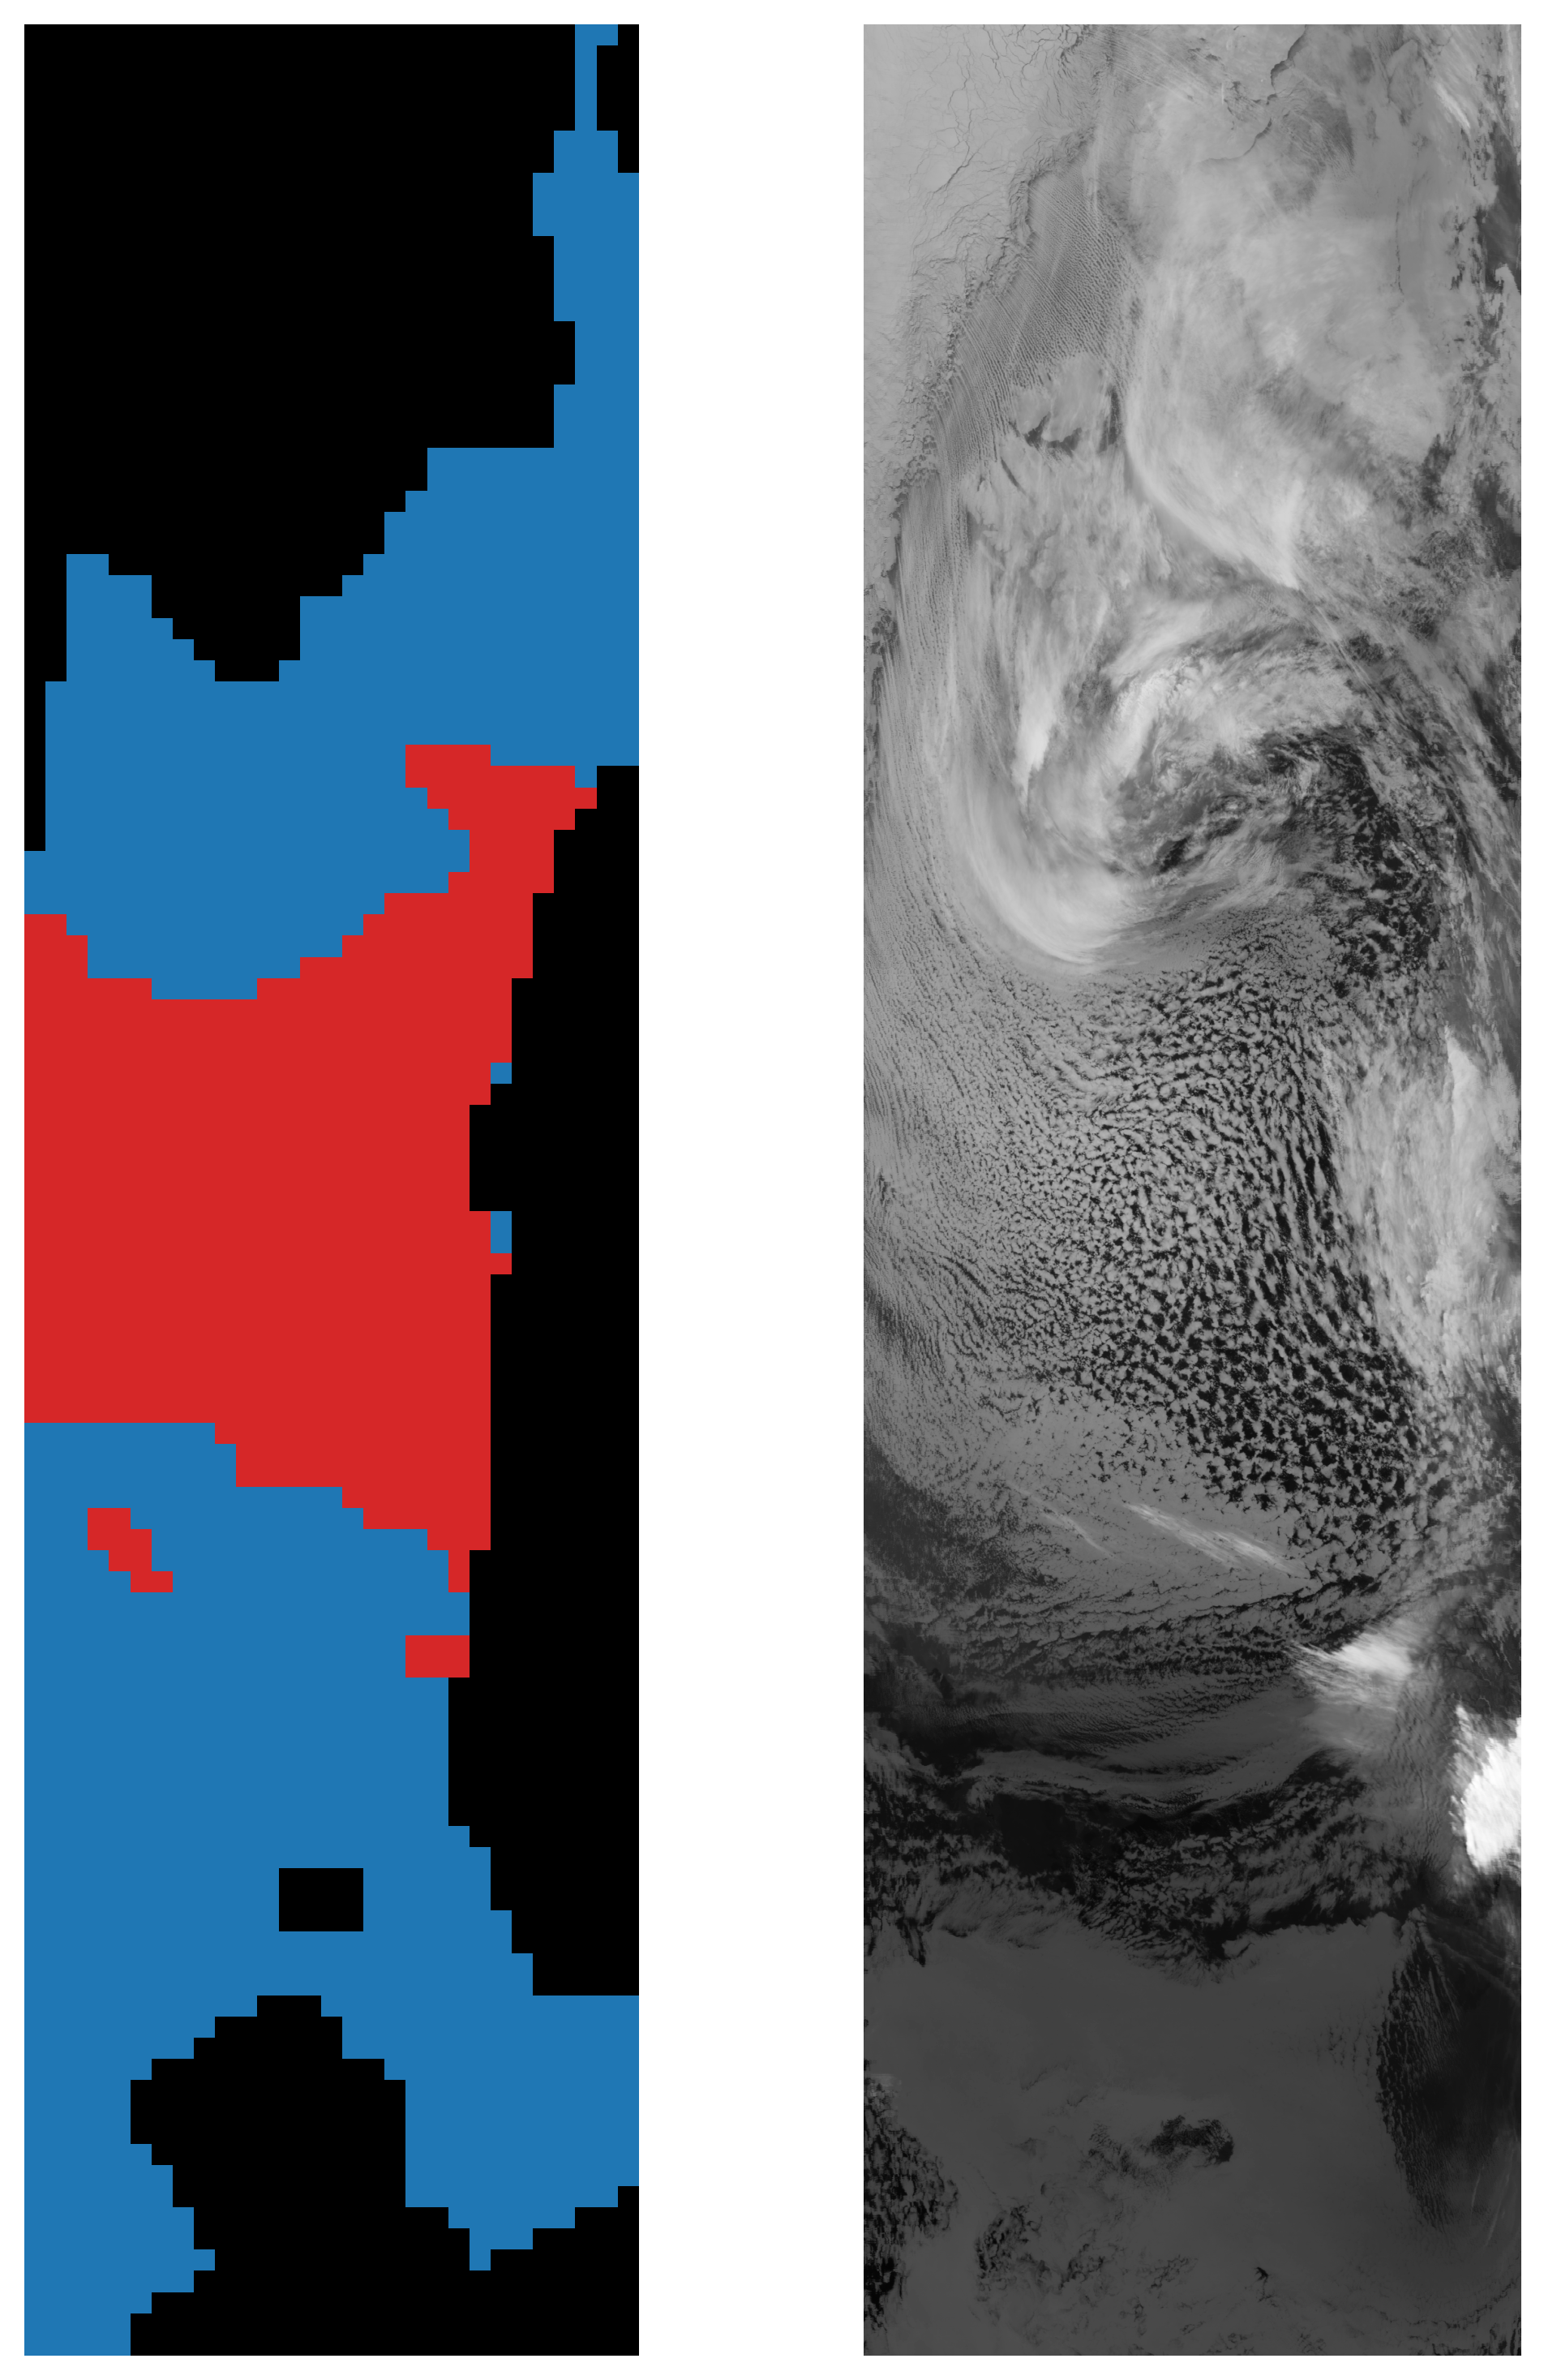

In [18]:
label_map_2 = np.where(~np.isin(label_map[-1], [3,6]), 0, label_map[-1])
label_map_2 = np.where(np.isin(label_map_2, [3,6]), 3, label_map_2)
label_map_2 = np.where(label_map[-1]==7, 7, label_map_2)
fig, axs = plt.subplots(1, 2, figsize=(8, 10), dpi=300)
axs[0].imshow(label_map_2, cmap=new_cmap, vmax=None, vmin=None, norm=norm)
axs[0].axis('off')
axs[1].imshow(x_test[-1], cmap="gray_r", vmax=None, vmin=None)
axs[1].axis('off')
plt.tight_layout()

In [ ]:
cao_labels = [7]
cao_likely_labels = [3]
cao_unlikely_labels = [8, 5, 0]
last_filter = 128
np.save(f"{data_loc}models/patch_size128/filter{last_filter}/clustering/cluster_{model_run_name}_filter{last_filter}_K{n_K}_cao_labels.npy", cao_labels)
np.save(f"{data_loc}models/patch_size128/filter{last_filter}/clustering/cluster_{model_run_name}_filter{last_filter}_K{n_K}_cao_likely_labels.npy", cao_likely_labels)
np.save(f"{data_loc}models/patch_size128/filter{last_filter}/clustering/cluster_{model_run_name}_filter{last_filter}_K{n_K}_cao_unlikely_labels.npy", cao_unlikely_labels)